# Exploring violations related to farming activity

To run this notebook, load SDWIS csv data files into the folder ``../../../data/sdwis/SDWIS``

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

STATE_CODE = 'VT'

DATA_DIR = '../../../../data'
SDWIS_DIR = os.path.join(DATA_DIR, 'sdwis')

In [2]:
# These contaminants are typically associated with farming activity.

FARM_CONTAMINANTS = [
    'ALACHLOR ESA',
    'Atrazine',
    'Carbofuran',
    '2,4-D',
    'Dalapon',
    '1,2-Dibromo-3-chloropropane',
    'Dinoseb',
    'Diquat',
    'Endothall',
    'Glyphosate',
    'Lindane',
    'Methoxychlor',
    'Nitrate',
    'Nitrite',
    'Oxamyl',
    'Picloram',
    'Simazine',
    'Toxaphene',
    '2,4,5-TP'
]

In [3]:
# Label data with full year, e.g., 2012 for 01-JUL-12
def get_year_from_mmddyy_series(ser, last_year_in_2000s=pd.Timestamp('now').year):
    """
    Expected input will be in the form 01-JUL-12.
    Output will be the year of the data.
    Assumes years will never be greater than current year.
    """
                                
    last_two_digits_year_cutoff = int(str(last_year_in_2000s)[-2:])
    
    # calculate last two digits of year
    return_series = ser.str.split('-').str[2].astype(int)
    
    # add first two digits
    return_series += (
        + (2000*(return_series <= last_two_digits_year_cutoff))
        + (1900*(return_series > last_two_digits_year_cutoff))
    )
    
    return return_series

def print_water_system_violations(water_system_df, viol_df):
    viol_df = viol_df.merge(water_system_df, left_on='VIOLATION.PWSID', right_on='WATER_SYSTEM.PWSID')
    print('# water systems: ' + str(water_system_df.shape[0]))
    print('# violations: ' + str(viol_df.shape[0]))
    print('# reporting violations: ' \
          + str(viol_df[viol_df['VIOLATION.VIOLATION_CATEGORY_CODE'] == 'MR'].shape[0]))
    print('# health violations: ' \
          + str(viol_df[viol_df['VIOLATION.IS_HEALTH_BASED_IND'] == 'Y'].shape[0]))

In [4]:
# read input files

viol = pd.read_csv(os.path.join(SDWIS_DIR, 'VIOLATION.csv'),
                   sep=',',
                   dtype={'VIOLATION.CONTAMINANT_CODE': np.str},
                   low_memory=False)

ws = pd.read_csv(os.path.join(SDWIS_DIR, 'WATER_SYSTEM.csv'),
                 low_memory=False)

wsf = pd.read_csv(os.path.join(SDWIS_DIR, 'WATER_SYSTEM_FACILITY.csv'),
                  low_memory=False)

# this file currently only contains entries for VT, can be expanded to include other states
# source: https://www.nass.usda.gov/Quick_Stats/CDQT/chapter/2/table/1/state/VT/county/027
farms = pd.read_csv(os.path.join(DATA_DIR, 'usda/farm_operations.csv'))

contaminants = pd.read_csv(os.path.join(SDWIS_DIR, 'contaminant-codes.csv'),
                           sep=',',
                           dtype={'CODE': np.str})

In [5]:
last_two_digits_current_year = int(str(pd.Timestamp('now').year)[-2:])

viol['VIOLATION.YEAR'] = get_year_from_mmddyy_series(viol['VIOLATION.COMPL_PER_BEGIN_DATE'])

In [6]:
# violations in 2017
viol_2017 = viol[viol['VIOLATION.YEAR'] == 2017]
viol_2017.head()

,VIOLATION.PWSID,VIOLATION.VIOLATION_ID,VIOLATION.FACILITY_ID,VIOLATION.POPULATION_SERVED_COUNT,VIOLATION.NPM_CANDIDATE,VIOLATION.PWS_ACTIVITY_CODE,VIOLATION.PWS_DEACTIVATION_DATE,VIOLATION.PRIMARY_SOURCE_CODE,VIOLATION.POP_CAT_5_CODE,VIOLATION.PRIMACY_AGENCY_CODE,...,VIOLATION.RTC_DATE,VIOLATION.PUBLIC_NOTIFICATION_TIER,VIOLATION.ORIGINATOR_CODE,VIOLATION.SAMPLE_RESULT_ID,VIOLATION.CORRECTIVE_ACTION_ID,VIOLATION.RULE_CODE,VIOLATION.RULE_GROUP_CODE,VIOLATION.RULE_FAMILY_CODE,Unnamed: 34,VIOLATION.YEAR
54,NH2539010,1700027,NaN,1000,Y,A,NaN,GW,2,NH,...,NaN,3,S,NaN,NaN,111,100,110,NaN,2017
55,NH2539010,1700026,NaN,1000,Y,A,NaN,GW,2,NH,...,NaN,2,S,NaN,NaN,111,100,110,NaN,2017
205,NY2621115,911,NaN,120,N,A,NaN,GW,1,NY,...,20-OCT-17,3,S,NaN,NaN,500,500,500,NaN,2017
207,NY5507077,6617,NaN,45,N,A,NaN,GW,1,NY,...,11-MAY-17,3,S,NaN,NaN,500,500,500,NaN,2017
208,NY5507077,6618,NaN,45,N,A,NaN,GW,1,NY,...,NaN,3,S,NaN,NaN,111,100,110,NaN,2017


In [7]:
# Filter only to systems in Vermont
ws = ws.loc[
    (
        ws['WATER_SYSTEM.PRIMACY_AGENCY_CODE'] == STATE_CODE)
        & (ws['WATER_SYSTEM.PWS_ACTIVITY_CODE'] == 'A')
]

In [8]:
farms = farms.drop(['state_fips', 'county_code', 'commodity', 'domain_category'], axis=1)
farms['county'] = farms['county'].str.capitalize()
farms.head()

,state,county,data _item,2017,2012,2007,2002,1997
0,VERMONT,Addison,FARM OPERATIONS - ACRES OPERATED,169874,208362,187482,193376,209469
1,VERMONT,Bennington,FARM OPERATIONS - ACRES OPERATED,33079,41387,36580,41126,34766
2,VERMONT,Caledonia,FARM OPERATIONS - ACRES OPERATED,86999,81828,81946,84318,99488
3,VERMONT,Chittenden,FARM OPERATIONS - ACRES OPERATED,64226,73583,83382,76679,91186
4,VERMONT,Essex,FARM OPERATIONS - ACRES OPERATED,42801,25491,26732,19838,25443


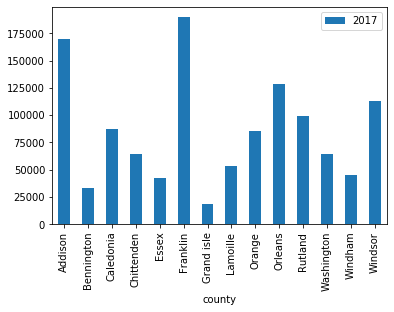

In [9]:
farms[['county', '2017']].plot.bar(x='county', y='2017')

In [10]:
viol_2017_county = pd.merge(viol_2017, ws, left_on='VIOLATION.PWSID', \
                            right_on='WATER_SYSTEM.PWSID')
viol_2017_county = viol_2017_county[['VIOLATION.PWSID', 'VIOLATION.CONTAMINANT_CODE', 'WATER_SYSTEM.COUNTIES_SERVED']]
viol_2017_county.head()

,VIOLATION.PWSID,VIOLATION.CONTAMINANT_CODE,WATER_SYSTEM.COUNTIES_SERVED
0,VT0005382,2996,Rutland
1,VT0005382,2992,Rutland
2,VT0005382,2991,Rutland
3,VT0005382,2990,Rutland
4,VT0005382,2989,Rutland


In [11]:
viol_2017_county_contaminant = pd.merge(viol_2017_county, contaminants, \
                            left_on='VIOLATION.CONTAMINANT_CODE', \
                           right_on='CODE')
viol_2017_county_contaminant_subset = viol_2017_county_contaminant[['VIOLATION.PWSID', \
                                     'NAME', \
                                     'WATER_SYSTEM.COUNTIES_SERVED']]
viol_2017_county_contaminant_subset.head()

,VIOLATION.PWSID,NAME,WATER_SYSTEM.COUNTIES_SERVED
0,VT0005382,STYRENE,Rutland
1,VT0005318,STYRENE,Windsor
2,VT0005536,STYRENE,Windham
3,VT0021599,STYRENE,Addison
4,VT0005049,STYRENE,Caledonia


In [12]:
viol_2017_county_contaminant_subset = viol_2017_county_contaminant_subset.loc[
    viol_2017_county_contaminant_subset['NAME'].isin(pd.Series(FARM_CONTAMINANTS).str.upper())
]

## Possible farm-related contaminant violations by county

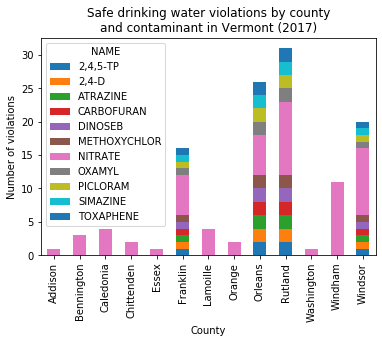

In [13]:
viol_2017_county_contaminant_subset.groupby(['WATER_SYSTEM.COUNTIES_SERVED', 'NAME'])\
    .size().unstack().plot.bar(stacked=True)
plt.title('Safe drinking water violations by county\nand contaminant in Vermont (2017)')
plt.xlabel('County')
plt.ylabel('Number of violations')

plt.show()